# Google Analytics Customer Revenue

## Import libreries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os


In [ ]:
import random
import json
from pandas.io.json import json_normalize

from scipy import stats
from datetime import datetime

from sklearn import model_selection
import xgboost as xgb 
import lightgbm as lgb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import data

In [ ]:
columns = ['device','geoNetwork','totals']

In [ ]:
p = 0.1

In [ ]:
def json_read(df):
    data_frame = file_dir + df
    
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'}, 
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df

In [ ]:
file_dir = '/content/gdrive/MyDrive/MASTER DS/ML. Supervisado'
file_name = '/GACR_def.csv'

In [ ]:
%%time
random.seed(42)
df = json_read(file_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


Loaded GACR_def.csv. Shape: (90249, 42)
CPU times: user 11.3 s, sys: 1.58 s, total: 12.9 s
Wall time: 15.5 s


In [ ]:
df.shape

(90249, 42)

## EDA

In [ ]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90249 entries, 0 to 90248
Columns: 42 entries, Unnamed: 0 to totals.transactionRevenue
dtypes: bool(1), int64(5), object(36)
memory usage: 28.3+ MB


In [ ]:
df.head().T

,0,1,2,3,4
Unnamed: 0,1,7,9,12,19
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
fullVisitorId,377306020877927890,537222803633850821,9499785259412240342,357659889600827884,3696906537737368442
sessionId,377306020877927890_1472880147,537222803633850821_1472812602,9499785259412240342_1472812272,357659889600827884_1472839882,3696906537737368442_1472856874
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1472880147,1472812602,1472812272,1472839882,1472856874
visitNumber,1,1,1,1,1
visitStartTime,1472880147,1472812602,1472812272,1472839882,1472856874
device.browser,Firefox,Chrome,Firefox,Safari,Chrome


In [ ]:
#PONEMOS EL SESSIONID COMO INDICE  
df.set_index('sessionId', inplace = True)

In [ ]:
#ELIMINAMOS LAS OTRAS DOS QE TAMBIEN NOS DAN INDICES
df_ids = ['fullVisitorId','visitId']

In [ ]:
df.drop(df_ids, axis =1, inplace = True)

In [ ]:
#VEMOS qué variables son numéricas

In [ ]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,90249.0,4.517847e+05,2.613238e+05,1.000000e+00,2.254420e+05,4.512880e+05,6.777830e+05,9.036510e+05
date,90249.0,2.016587e+07,4.697879e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitNumber,90249.0,2.241920e+00,8.800759e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.930000e+02
visitStartTime,90249.0,1.484998e+09,9.021906e+06,1.470039e+09,1.477560e+09,1.483901e+09,1.492727e+09,1.501657e+09


In [ ]:
#VEMOS LAS COLUMNAS CATEGORICAS
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90249,8,Organic Search,37993
socialEngagementType,90249,1,Not Socially Engaged,90249
device.browser,90249,32,Chrome,62130
device.browserVersion,90249,1,not available in demo dataset,90249
device.browserSize,90249,1,not available in demo dataset,90249
device.operatingSystem,90249,14,Windows,34835
device.operatingSystemVersion,90249,1,not available in demo dataset,90249
device.isMobile,90249,2,False,66496
device.mobileDeviceBranding,90249,1,not available in demo dataset,90249
device.mobileDeviceModel,90249,1,not available in demo dataset,90249


In [ ]:
#
df['totals.bounces'].nunique(dropna = False) == 1

False

In [ ]:
df['totals.bounces'].describe()

count     45130
unique        1
top           1
freq      45130
Name: totals.bounces, dtype: object

In [ ]:
#CREAMOS UNA LISTA DE COLUMNAS CONSTANTES
constant_columns = []

In [ ]:
df.nunique?

In [ ]:
#HACEMOS UN FOR LOOP QUE BUSQUE POR CADA COLUMNA CUALES DE ELLOS TENIAN UNA SOLA ETIQUETA CONSIDERANDO TAMBIEN LOS NULOS Y LUEGO GENERAMOS LA LISTA
for col in df.columns:
  if df[col].nunique(dropna = False) == 1:
    constant_columns.append(col)
    #df.drop(col, axis = 1, inplace = True)

In [ ]:
#GENERAMOS LA LISTA
constant_columns = [col for col in df.columns if df[col].nunique(dropna = False) == 1 ]

In [ ]:
#VEMOS LA CANTIDAD DE COLUMNAS QUE QUEDARON CON ESTA CARACTERISTICA
len(constant_columns)

18

In [ ]:
#LAS ELIMINAMOS YA QUE NO ME APORTARAN MUCHA INFORMACION PARA EL DESICION TREE
df.drop(constant_columns, axis = 1 , inplace = True)

In [ ]:
#VEO QUE ME QUEDARON 21 COLUMNAS AHORA 
df.shape

(90249, 21)

In [ ]:
df.head().T

sessionId,377306020877927890_1472880147,537222803633850821_1472812602,9499785259412240342_1472812272,357659889600827884_1472839882,3696906537737368442_1472856874
Unnamed: 0,1,7,9,12,19
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
visitNumber,1,1,1,1,1
visitStartTime,1472880147,1472812602,1472812272,1472839882,1472856874
device.browser,Firefox,Chrome,Firefox,Safari,Chrome
device.operatingSystem,Macintosh,Windows,Windows,iOS,Windows
device.isMobile,False,False,False,True,False
device.deviceCategory,desktop,desktop,desktop,mobile,desktop
geoNetwork.continent,Oceania,Oceania,Europe,Asia,Americas


In [ ]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
#GENERO UNA VARIABLE DESCRIPTIVA DEL DATAFRAME
df_description = df.describe(include = 'all').T

In [ ]:
#AHORA UNA VEZ TENGO LIMPIAS LAS COLUMNAS CON LAS QUE VOY A TRABAJAR IMPORTO UN EXCEL PARA IR EDITANDO Y VIENDO QUE VOY HACIENDO EN CADA COLUMNA 
from google.colab import files
df_description.to_excel('df_description_ds2111.xlsx')
files.download('df_description_ds2111.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Target Analysis

In [ ]:
#DEFINO CUAL ES EL TARGET QUE SON LOS INGRESOS POR TRANSACCIONES 
TARGET = 'totals.transactionRevenue'

In [ ]:
df[TARGET].describe()

count         1177
unique         829
top       16990000
freq            25
Name: totals.transactionRevenue, dtype: object

In [ ]:
#VEO QUE me lo coge como object -> es numerico

In [ ]:
#LO PASO A VARIABLE NUMERICA 
df[TARGET] = df[TARGET].astype(float)

In [ ]:
df[TARGET].describe()

count    1.177000e+03
mean     1.451774e+08
std      5.465525e+08
min      9.000000e+04
25%      2.399000e+07
50%      5.002000e+07
75%      1.045500e+08
max      1.602375e+10
Name: totals.transactionRevenue, dtype: float64

In [ ]:
#elimino nulos del target

df[TARGET].fillna(0.0, inplace = True)

In [ ]:
df[TARGET].describe()

count    9.024900e+04
mean     1.893359e+06
std      6.452778e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.602375e+10
Name: totals.transactionRevenue, dtype: float64

In [ ]:
#AHORA REVISO CUALES Y CUANTS SON AQUELLAS SESIONES QUE SI HICIERON UNA COMPRA, HACIENDO EL TARGET MAYOR A 0
df[df[TARGET] >0][TARGET]

sessionId
4755168908070236728_1472849608     63840000.0
8007300615127214527_1472850417     35390000.0
1881458907401964229_1472849525    103240000.0
0643132668463442280_1472867400     25680000.0
7168226225550508027_1485452166    593910000.0
                                     ...     
1677668617700674850_1499647144     67730000.0
9710480501909231921_1483562473    155970000.0
2591017631506070831_1483561743    135920000.0
6726478899201625475_1483541553     23180000.0
3301001176863952275_1483599074     22970000.0
Name: totals.transactionRevenue, Length: 1177, dtype: float64

In [ ]:
#PARA QUE LOS NUMEROS ESTEN MAS CLAROS DIVIDO LOS VALORES ANTERIORES POR MIL
df[df[TARGET] >0][TARGET]/1000000

sessionId
4755168908070236728_1472849608     63.84
8007300615127214527_1472850417     35.39
1881458907401964229_1472849525    103.24
0643132668463442280_1472867400     25.68
7168226225550508027_1485452166    593.91
                                   ...  
1677668617700674850_1499647144     67.73
9710480501909231921_1483562473    155.97
2591017631506070831_1483561743    135.92
6726478899201625475_1483541553     23.18
3301001176863952275_1483599074     22.97
Name: totals.transactionRevenue, Length: 1177, dtype: float64

In [ ]:
#AGREGO EL TARGET AL DATAFRAME
df[TARGET] = df[TARGET]/1000000

In [ ]:
df[TARGET].describe()

count    90249.000000
mean         1.893359
std         64.527785
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      16023.750000
Name: totals.transactionRevenue, dtype: float64

In [ ]:
df[df[TARGET] >0][TARGET].describe()

count     1177.000000
mean       145.177375
std        546.552506
min          0.090000
25%         23.990000
50%         50.020000
75%        104.550000
max      16023.750000
Name: totals.transactionRevenue, dtype: float64

In [ ]:
#HAGO QUE LA COLUMNA DEL TARGET SEA IGUAL A SOLO AQUELLOS QUE SI HICIERON UNA COMPRA

df['visitWithTransaction'] = (df[TARGET] >0).astype(int)

In [ ]:
#VEO LA MEDIA Y VEMOS QUE HAY MUY POCAS COMPRAS, POR LO CUAL AL MODELO LE COSTARA PREDECIR CUANDO ALGUIEN HACE UNA COMPRA
#Y AUN MAS PREDECIR VALORES ALTOS DE COMPRAS
df['visitWithTransaction'].mean()*100

1.3041695752861526

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


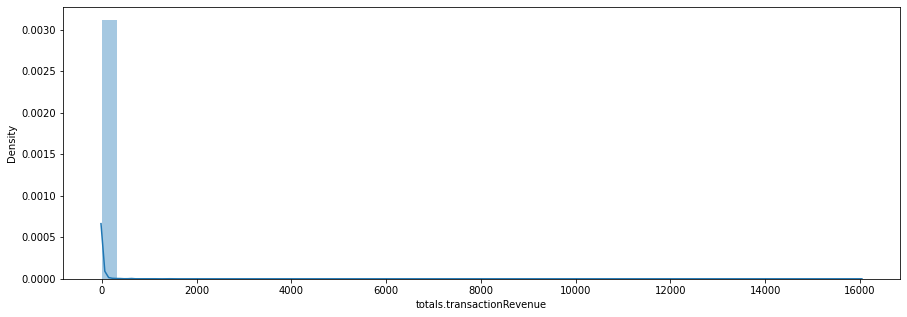

In [ ]:
#HAGO UN PLOT DE LA DISTRIBUCION DEL TARGET
plt.figure(figsize = (15,5))

sns.distplot(df[TARGET])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


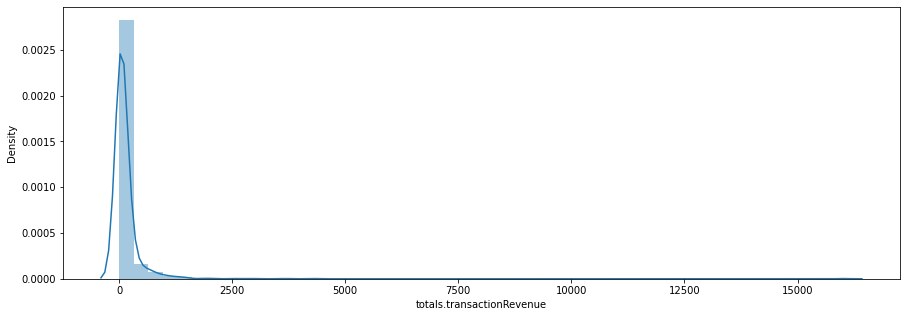

In [ ]:
#AHORA PLOTEO SOLO AQUELLOS VALORES QUE HICIERON COMPRAS
plt.figure(figsize = (15,5))

sns.distplot(df[df['visitWithTransaction'] == 1][TARGET])

In [ ]:
#ESTO LO HAGO PARA QUE LOS QUE SEAN CEROS NO SE ME HAGAN INFINITO EN EL LOGARITMO
def suma_uno(x):
  return x +1

In [ ]:
#PARA QUE MEJORE LA DISTRIBUCION DEL TARGET LO HAGO LOGARITMICO 
TARGET_LN = 'totals.transactionRevenueLN'

In [ ]:
#EL APPLY Y LAMBDA ME PERMITE PONER CUALQUIER FUNCION
df[TARGET_LN] = df[TARGET].apply(lambda x: np.log1p(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


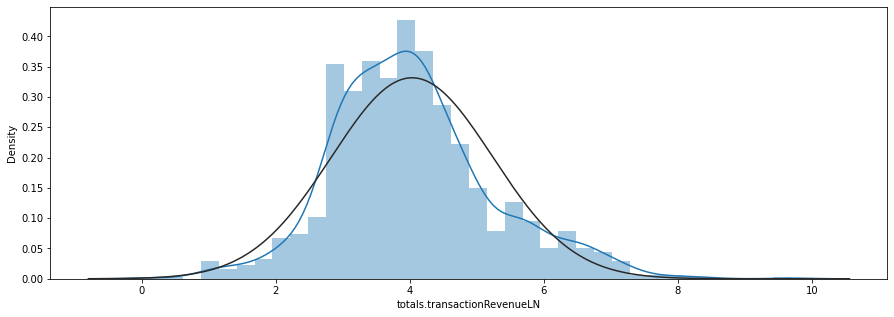

In [ ]:
#AHORA SI PLOTEO EL TARGET LOGARIRMICO Y TENGO UNA DISTRIBUCION MAS PARECIDA A LA NORMAL
plt.figure(figsize = (15,5))

sns.distplot(df[df['visitWithTransaction'] == 1][TARGET_LN], fit = stats.norm)

## Device Browser

In [ ]:
#OMIENZO ANALIZANDO LA VARIABLES CATEGORICAS DE TIPO DE DISPOSIVO, VEO QUE HAY 32 ETIQUETAS Y QUE HAY 8 QUE SON MAS SIGNIFICATIVAS
df['device.browser'].describe()

count      90249
unique        32
top       Chrome
freq       62130
Name: device.browser, dtype: object

In [ ]:
#AQUI HAGO UNA LISTA DE QUELLOS QUE SON MAS FRECUENTES
top_browsers = df['device.browser'].value_counts().head(8)

In [ ]:

top_browsers_list = top_browsers.index.to_list()

In [ ]:
#CREO OTRA COLUMNA PARA TODOS AQUELLOS QUE SEAN MINORITARIOS Y LA LLAMO OTROS
top_browsers_list.append('Others')

In [ ]:
top_browsers_list = list(set(top_browsers_list))

In [ ]:
#HAY 4 TIPOS DE CATEGORIAS DISTINTAS EN PYTHON, EL CATEGORICAL Y OBJECT SON PRACTICAMENTE LO MISMO, LA DIFERENCIA ESTA EN QUE EN AMBAS
#POR DETRAS PYTHON LO GRABA EN UNA TABLA, EN ESTA TABLITA QE TIENE PUEDE SER ESTATICA O DINAMICA, EN EL OBJECT LA VA ACTUALIZANDO
#PERO EN EL CATEGORICAL LO UNICO QUE ME VA A PERMITIR ES QUE HAYA ESAS ETIQUETAS, SI ENCUENTRO OTRA DISTINTA LA PONE EN OTHERS
df['device.browser'] = pd.Categorical(df['device.browser'], categories = top_browsers_list)

In [ ]:
#AHORA VEO CUANTOS SERVIDORES QUEDAON
df['device.browser'].value_counts(dropna = False)

Chrome               62130
Safari               18207
Firefox               3569
Internet Explorer     1930
NaN                   1350
Edge                  1020
Android Webview        785
Safari (in-app)        661
Opera Mini             597
Others                   0
Name: device.browser, dtype: int64

In [ ]:
#RELLENO LOS NULOS Y LOS PONGO EN OTHERS
df['device.browser'].fillna('Others', inplace = True)

In [ ]:
df['device.browser'].value_counts(dropna = False)

Chrome               62130
Safari               18207
Firefox               3569
Internet Explorer     1930
Others                1350
Edge                  1020
Android Webview        785
Safari (in-app)        661
Opera Mini             597
Name: device.browser, dtype: int64

### Analisis de la variable

In [ ]:
#ANALIZO LA VARIABLE CON RESPECTO AL TARGET, PARA ESTO HACEMOS UNA PIVOT TABLE QUE ERA UNA TABLA DONDE METIAMOS
#DOS VARIABLES PARA VER COMO SE CORRELAIONABAN Y COMO FUNCIONES DE AGREGACION PONEMOS EL LEN Y EL NP MEDIAN
#MIRO PARA CADA ETIQUETA DEL BROWSER CUANTAS COMPRAS TENGO Y LA MEDIA DE ESE TARGET 
#TENGO QUE TENER CUIDADO CUANDO ELIJO EL TARGET, PORQUE EL TARGET SOLO SIN LOG ME VA A DAR DATOS MUY TIRADOS A LA IZQUIERDA
#Y EN ESTE CASO LA MEDIA NO SERA MUY REPRESENTATIVA
#ENTONCES O TOMO EL TARGET LN Y CALCULO LA MEDIA, O SIGO UTILIZANDO TARGET SOLO Y METO LA MEDIANA (VALORES MAS FRECUENTES)
results_df = df[df[TARGET] >0].pivot_table(index = 'device.browser', values = TARGET, aggfunc = [len, np.median] )

In [ ]:
df[df[TARGET] >0].pivot_table(index = 'device.browser', values = TARGET, aggfunc = [len, np.median] )

,len,median
,totals.transactionRevenue,totals.transactionRevenue
device.browser,,
Edge,10.0,20.905
Chrome,1065.0,52.600
Firefox,17.0,20.980
Safari,74.0,26.450
Android Webview,1.0,49.990
Others,2.0,63.240
Internet Explorer,8.0,16.980


In [ ]:
#UNA VEZ QUE DEFINI LA COLUMNA RESULTADOS RENOMBRO LAS COLUMNAS Y PONGO TRANSACCIONES(AL LARGO) Y LA MEDIANA MEDIAN DE INGRESOS
results_df.columns = ['transactions', 'median_revenue']

In [ ]:
#AQUI AGREGO OTRA COLUMNA QUE INDICA EL NUMERO DATOS POR CADA ETIQUETA
results_df['n_rows'] = df['device.browser'].value_counts()

In [ ]:
results_df

,transactions,median_revenue,n_rows
device.browser,,,
Edge,10.0,20.905,1020
Chrome,1065.0,52.600,62130
Firefox,17.0,20.980,3569
Safari,74.0,26.450,18207
Android Webview,1.0,49.990,785
Others,2.0,63.240,1350
Internet Explorer,8.0,16.980,1930


In [ ]:
df['device.browser'].value_counts()

Chrome               62130
Safari               18207
Firefox               3569
Internet Explorer     1930
Others                1350
Edge                  1020
Android Webview        785
Safari (in-app)        661
Opera Mini             597
Name: device.browser, dtype: int64

In [ ]:
#DEL RESULTADO ANTERIOR HAGO UNA COLUMNA DE PORCENTAJE
results_df['pct_rows'] = df['device.browser'].value_counts(normalize = True)

In [ ]:
#ENTONCES AHORA TENEMOS EL TOTAL DE VISITAS VERSUS LA CANTIDAD DE TRANSACCIONES, HACEMOS LA DIFERENCIA ENTRE AMBOS 
#Y TENEMOS EL % DE TRANSACCIONES SOBRE EL TOTAL DE VISITAS 
results_df['pct_transactions'] = results_df['transactions'] / results_df['n_rows']

In [ ]:
#AGREGO TODAS LAS COLUMNAS AL DATAFRAME, LAS ORDENO 
#NUM DE FILAS TOTALES (N_ROWS)
#PORCENTAJE Q REPRESENTAN SOBRE EL TOTAL
#NUMERO TOTAL DE TRANSACCIONES
#PORCENTAJE DE TRANSACCIONES
#Y LA MEDIA QUE SE GASTA
results_df = results_df[['n_rows','pct_rows','transactions','pct_transactions','median_revenue']]

In [ ]:
#SERA IMPORTANTE ESTA VARIABLE PARA PREDECIR EL IMPORTE? ENTENDER QUIEN COMPRA Y QUIEN NO Y ENTRE ESOS QUE COMPRE CUANTO GASTARAN
#EL ALGORITMO VERA QUE SI BIEN EN CHROME ES MAS ALTO EL PORCENTAJE DE COMPRA EN OTROS GASTAN MAS PERO SON MENOS LOS QUE COMPRAN
results_df

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
device.browser,,,,,
Edge,1020,0.011302,10.0,0.009804,20.905
Chrome,62130,0.688429,1065.0,0.017141,52.600
Firefox,3569,0.039546,17.0,0.004763,20.980
Safari,18207,0.201742,74.0,0.004064,26.450
Android Webview,785,0.008698,1.0,0.001274,49.990
Others,1350,0.014959,2.0,0.001481,63.240
Internet Explorer,1930,0.021385,8.0,0.004145,16.980


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


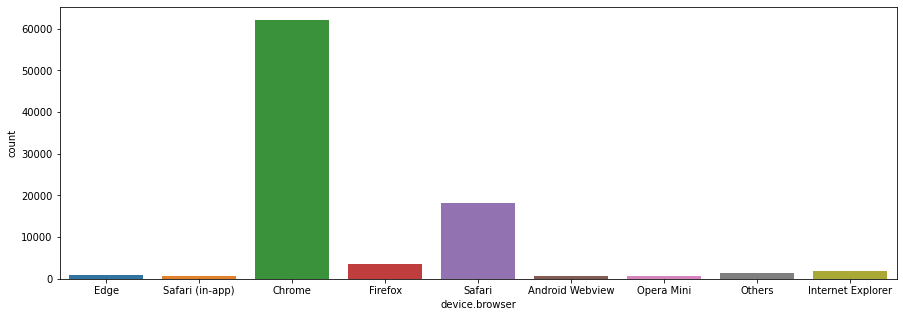

In [ ]:
#HACEMOS UN PLOTEO DEL CONTEO DE LOS USARIOS CON TALES SERVIDORES
plt.figure(figsize = (15,5))
sns.countplot(df['device.browser'])

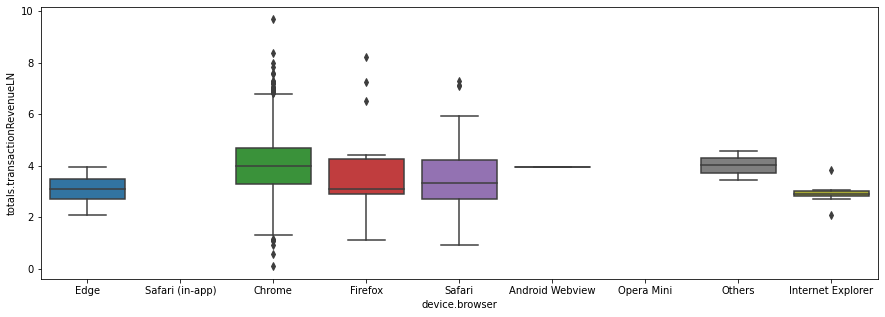

In [ ]:
#AHORA HACEMOS UN BOXPLOT CON EL TARGET EN EL EJE Y PERO SOLO VOY A VER AQUELLOS QUE HAYAN HECHO TRANSACCIONES
plt.figure(figsize = (15,5))
sns.boxplot(data = df[df[TARGET]>0], x = 'device.browser', y = TARGET_LN )

In [ ]:
#CREO UNA FUNCION PARA PLOTEAR LAS VARIABLES CATEGORICAS MAS RAPIDO, DONDE PONGO EL NOMBRE DE DATAFRAME, LA COLUMNA QUE QUIERO VER Y EL TARGET EN LOG
def plot_cat_values(dataframe, column,target_col):
  plt.figure(figsize = (15,5))

  ax1 = plt.subplot(2,1,1) # 2 filas, 1 columna, posicion 1
  ax1 = sns.countplot(dataframe[column], order = list(dataframe[column].unique()) )

  ax2 = plt.subplot(2,1,2)
  ax2 = sns.boxplot(data = dataframe[dataframe[target_col]>0], x = column, y = target_col , order = list(dataframe[column].unique())  )
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


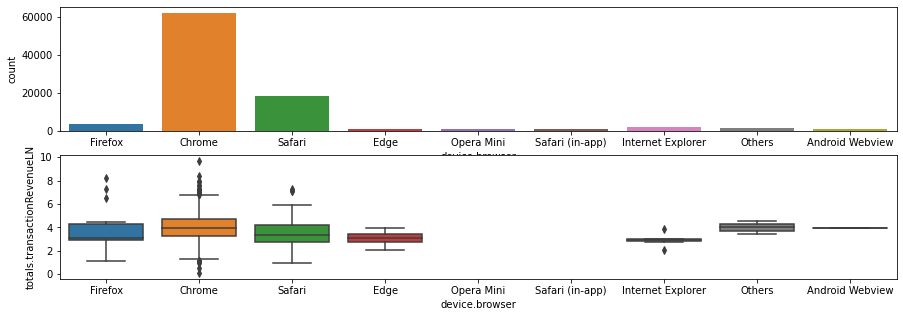

In [ ]:
#PRUEBO LA FUNCION CON 
plot_cat_values(df, 'device.browser',TARGET_LN)

In [ ]:
#CON ESTA FUNCION PARA EXPLORAR LAS VARIABLES CATEGORICAS
#VAMOS A HACER LAS TABLAS COMPARATIVAS ENTRE LAS VARIABLES Y EL TARGET, TODO LO QUE HICIMOS ANTERIORMENTE
#PRIMERO GENERAMOS UNA VARIABLE DATAFRAME DE RESULTADOS, CON EL TARGET  A CERO ES DECIR SOLO LOS QUE COMPRARON
#COMPARADO CON LA COLUMNA Y EL TARGET, Y LAS FUNCIONES DE AGREGACION Q DAN LA CANTIDAD DE DATOS DE LA COLUMNA TOTAL Y LA MEDIANA
#DESPUES LA RENOMBRA AL TOTAL DE TRANSACCIONES Y LA MEDIA DE LOS QUE SE GASTO
#DESPUES EL NUMERO DE VALORES TOTALES POR CADA ETIQUETA CON EL VALUE COUNTS
#DESPUES HAGO EL PORCENTAJE DE LA CANTIDAD DE FILAS
#DESPUES EL PORCENTAJE DE TRANSACCIONES 
#LUEGO ORDENAR LOS RESULTADOS 
def explore_cat_values(dataframe, column,target_col):
  results_df = dataframe[dataframe[target_col] >0].pivot_table(index = column, values = target_col, aggfunc = [len, np.median] )
  results_df.columns = ['transactions', 'median_revenue']
  results_df['n_rows'] = dataframe[column].value_counts()
  results_df['pct_rows'] = dataframe[column].value_counts(normalize = True)
  results_df['pct_transactions'] = results_df['transactions'] / results_df['n_rows']
  return results_df[['n_rows','pct_rows','transactions','pct_transactions','median_revenue']]

In [ ]:
explore_cat_values(df, 'device.browser',TARGET_LN)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
device.browser,,,,,
Edge,1020,0.011302,10.0,0.009804,3.076698
Chrome,62130,0.688429,1065.0,0.017141,3.981549
Firefox,3569,0.039546,17.0,0.004763,3.090133
Safari,18207,0.201742,74.0,0.004064,3.312220
Android Webview,785,0.008698,1.0,0.001274,3.931630
Others,1350,0.014959,2.0,0.001481,4.006707
Internet Explorer,1930,0.021385,8.0,0.004145,2.888904


In [ ]:
#ESTA FUNCION ES LA QUE CREAMOS PARA UTILIZAR SOLO LAS ETIQUETAS QUE TENGAN MAYORES DATOS Y PONER 
#AQUELLOS CON DATOS POCO SIGNIFICANTES EN OTHERS
def set_Other(dataframe, column, num_values):
  top_browsers = dataframe[column].value_counts().head(num_values)
  top_browsers_list = top_browsers.index.to_list()
  top_browsers_list.append('Others')
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_browsers_list)
  return dataframe[column].fillna('Others')


#### Sistema operativo


In [ ]:
df['device.operatingSystem'].value_counts()

Windows          34835
Macintosh        25592
Android          12428
iOS              10620
Linux             3461
Chrome OS         2671
(not set)          452
Windows Phone      107
BlackBerry          27
Samsung             24
Firefox OS          10
Nintendo Wii         9
Nintendo WiiU        7
Xbox                 6
Name: device.operatingSystem, dtype: int64

In [ ]:
df['device.operatingSystem'] = set_Other(df, 'device.operatingSystem', 6)

In [ ]:
explore_cat_values(df, 'device.operatingSystem',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
device.operatingSystem,,,,,
Windows,34835,0.385988,247.0,0.007091,46.840
Macintosh,25592,0.283571,652.0,0.025477,55.990
Android,12428,0.137708,48.0,0.003862,31.735
iOS,10620,0.117674,51.0,0.004802,21.990
Linux,3461,0.038349,65.0,0.018781,39.190
Chrome OS,2671,0.029596,114.0,0.042681,66.715


### is Mobile

In [ ]:
explore_cat_values(df, 'device.isMobile',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
device.isMobile,,,,,
False,66496,0.736806,1078,0.016212,52.66
True,23753,0.263194,99,0.004168,24.28


In [ ]:
# los que no vienen de móvil gasta más y convierte más

In [ ]:
df['device.isMobile'] = df['device.isMobile'].astype(int)

### Device category

In [ ]:
explore_cat_values(df, 'device.deviceCategory',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
device.deviceCategory,,,,,
desktop,66492,0.736762,1078,0.016212,52.66
mobile,20743,0.229842,90,0.004339,23.58
tablet,3014,0.033396,9,0.002986,24.99


In [ ]:
pd.crosstab(df['device.isMobile'], df['device.deviceCategory'])

device.deviceCategory,desktop,mobile,tablet
device.isMobile,,,
0,66482,13,1
1,10,20730,3013


##### channelGrouping

In [ ]:
explore_cat_values(df, 'channelGrouping',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
channelGrouping,,,,,
Direct,14178,0.157099,233,0.016434,57.580
Display,615,0.006814,10,0.016260,57.975
Organic Search,37993,0.420980,360,0.009475,35.150
Paid Search,2599,0.028798,45,0.017314,42.850
Referral,10607,0.117530,520,0.049024,54.370
Social,22568,0.250064,9,0.000399,67.180


In [ ]:
df['channelGrouping'].value_counts()

Organic Search    37993
Social            22568
Direct            14178
Referral          10607
Paid Search        2599
Affiliates         1678
Display             615
(Other)              11
Name: channelGrouping, dtype: int64

## Date

In [ ]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].dt.week
df['trimestre'] = df['date'].dt.quarter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [ ]:
df.drop('date', axis = 1 , inplace = True)

In [ ]:
explore_cat_values(df, 'weekday',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
weekday,,,,,
0,13959,0.154672,185,0.013253,55.240
1,14715,0.163049,220,0.014951,55.980
2,14697,0.162849,194,0.013200,47.395
3,14116,0.156412,211,0.014948,55.990
4,13032,0.144400,189,0.014503,52.070
5,9741,0.107935,81,0.008315,39.990
6,9989,0.110683,97,0.009711,42.600


### Visit Start Time

In [ ]:
df['visitStartTime'].head()

sessionId
377306020877927890_1472880147     1472880147
537222803633850821_1472812602     1472812602
9499785259412240342_1472812272    1472812272
357659889600827884_1472839882     1472839882
3696906537737368442_1472856874    1472856874
Name: visitStartTime, dtype: int64

In [ ]:
df['visitHour'] = df['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [ ]:
explore_cat_values(df[df['weekday']>=5], 'visitHour',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
visitHour,,,,,
0,664,0.033654,12,0.018072,54.030
1,790,0.040041,17,0.021519,42.950
2,752,0.038115,12,0.015957,44.790
3,814,0.041257,8,0.009828,44.690
4,746,0.037810,10,0.013405,32.185
5,729,0.036949,6,0.008230,27.185
6,705,0.035732,2,0.002837,47.185
7,773,0.039179,3,0.003881,102.930
8,757,0.038368,2,0.002642,205.350


#### Visit Number

In [ ]:
df['visitNumber'].describe()

count    90249.000000
mean         2.241920
std          8.800759
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        393.000000
Name: visitNumber, dtype: float64

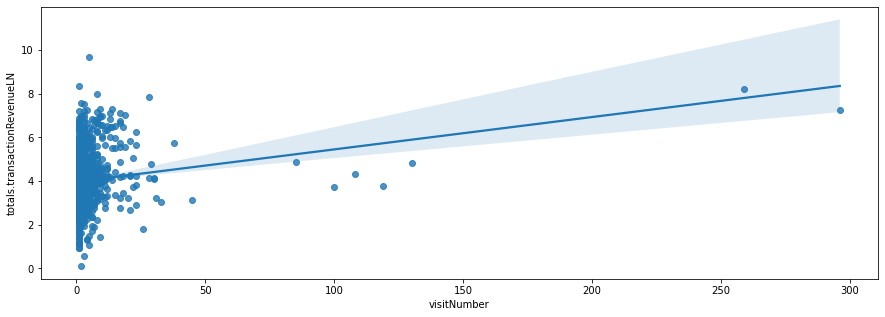

In [ ]:
plt.figure(figsize = (15,5))

sns.regplot(
    data = df[df[TARGET_LN]>0],
    x= 'visitNumber',
    y = TARGET_LN
)

In [ ]:
 df['visitNumber_log'] = df['visitNumber'].apply(lambda x: np.log1p(x))

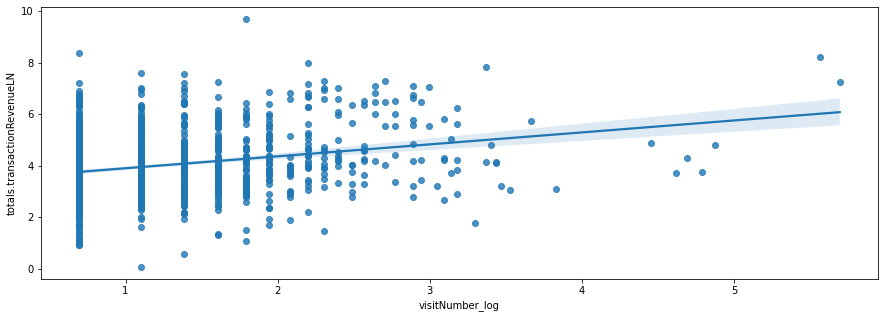

In [ ]:
plt.figure(figsize = (15,5))

sns.regplot(
    data = df[df[TARGET_LN]>0],
    x= 'visitNumber_log',
    y = TARGET_LN
)

In [ ]:
df[[TARGET,'visitNumber' ]].corr()

,totals.transactionRevenue,visitNumber
totals.transactionRevenue,1.000000,0.037356
visitNumber,0.037356,1.000000


In [ ]:
df[[TARGET_LN,'visitNumber_log' ]].corr()

,totals.transactionRevenueLN,visitNumber_log
totals.transactionRevenueLN,1.000000,0.102183
visitNumber_log,0.102183,1.000000


## Hits

In [ ]:
df['totals.hits'].describe()

count     90249
unique      162
top           1
freq      44737
Name: totals.hits, dtype: object

In [ ]:
df['totals.hits'] = df['totals.hits'].astype(int)

In [ ]:
df['totals.hits'].describe()

count    90249.000000
mean         4.572771
std          9.600290
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        500.000000
Name: totals.hits, dtype: float64

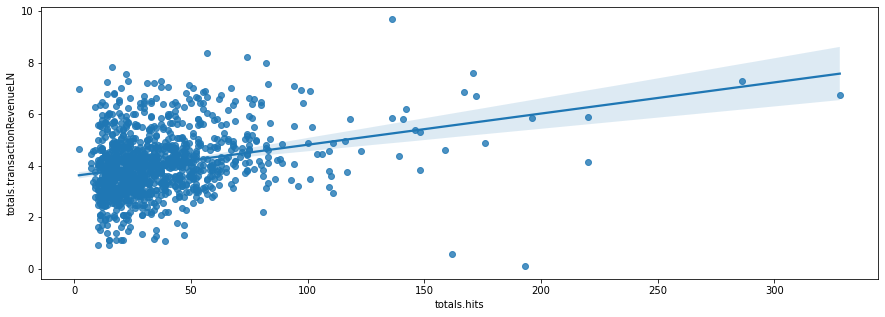

In [ ]:
plt.figure(figsize = (15,5))

sns.regplot(
    data = df[df[TARGET_LN]>0],
    x= 'totals.hits',
    y = TARGET_LN
)

In [ ]:
 df['totals.hits_log'] = df['totals.hits'].apply(lambda x: np.log1p(x))

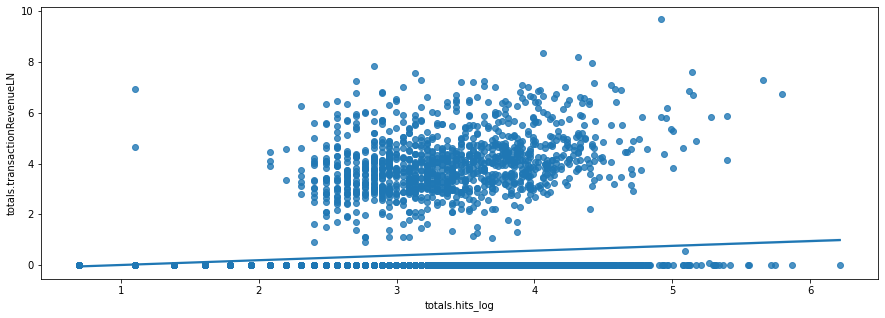

In [ ]:
plt.figure(figsize = (15,5))

sns.regplot(
    data = df,
    x= 'totals.hits_log',
    y = TARGET_LN
)

In [ ]:
df[[TARGET_LN,'totals.hits_log']].corr()

,totals.transactionRevenueLN,totals.hits_log
totals.transactionRevenueLN,1.000000,0.308658
totals.hits_log,0.308658,1.000000


In [ ]:

#### Pageviews

In [ ]:
df['totals.pageviews'].describe()

count     90236
unique      123
top           1
freq      45320
Name: totals.pageviews, dtype: object

In [ ]:
df['totals.pageviews'].fillna(0, inplace = True)

In [ ]:
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

In [ ]:
df['totals.pageviews'].describe()

count    90249.000000
mean         3.833450
std          6.996651
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        333.000000
Name: totals.pageviews, dtype: float64

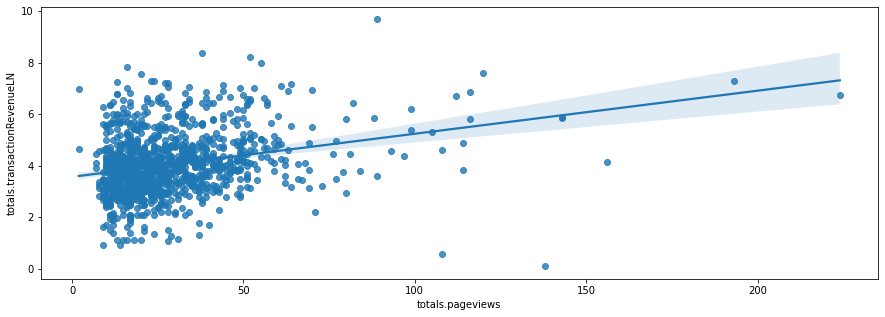

In [ ]:
plt.figure(figsize = (15,5))

sns.regplot(
    data = df[df[TARGET_LN]>0],
    x= 'totals.pageviews',
    y = TARGET_LN
)

In [ ]:
df[['totals.pageviews','totals.hits']].corr() #mucha correlacion, podemos eliminar una de las dos

,totals.pageviews,totals.hits
totals.pageviews,1.000000,0.986006
totals.hits,0.986006,1.000000


### GeoNetwork - continents

In [ ]:
explore_cat_values(df, 'geoNetwork.continent',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
geoNetwork.continent,,,,,
Americas,44972,0.498310,1154,0.025660,50.01
Asia,22414,0.248357,14,0.000625,55.47
Europe,19627,0.217476,8,0.000408,47.29
Oceania,1564,0.017330,1,0.000639,47.97


In [ ]:
df['geoNetwork.continent'].value_counts()

Americas     44972
Asia         22414
Europe       19627
Oceania       1564
Africa        1525
(not set)      147
Name: geoNetwork.continent, dtype: int64

### Subcontinent

In [ ]:
explore_cat_values(df, 'geoNetwork.subContinent',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
geoNetwork.subContinent,,,,,
Australasia,1549,0.017164,1,0.000646,47.970
Caribbean,274,0.003036,2,0.007299,51.085
Central America,1566,0.017352,2,0.001277,66.940
Eastern Asia,4691,0.051978,6,0.001279,77.985
Eastern Europe,4489,0.049740,2,0.000446,46.225
Northern America,39026,0.432426,1143,0.029288,49.990
Northern Europe,5788,0.064134,3,0.000518,62.600
South America,4106,0.045496,7,0.001705,83.770
Southeast Asia,7842,0.086893,3,0.000383,127.120


### Country

In [ ]:
results_df_country = explore_cat_values(df, 'geoNetwork.country',TARGET)

In [ ]:
last_countries = results_df_country[results_df_country['n_rows'] > 500].sort_values(by = 'pct_transactions' ).head(4).index.to_list()

In [ ]:
best_countries = results_df_country[results_df_country['n_rows'] > 500].sort_values(by = 'pct_transactions' ).tail(4).index.to_list()

In [ ]:
country_list = last_countries + best_countries

In [ ]:
country_list #lista definitiva de los paises a los que quiero en el OHE

['United Kingdom',
 'India',
 'Turkey',
 'Germany',
 'Sweden',
 'Singapore',
 'Canada',
 'United States']

In [ ]:
def set_Other_PataNegra(dataframe, column,target_col, num_min_rows,top_n):

  results_df_cat = explore_cat_values(dataframe, column,target_col)
  last_countries = results_df_cat[results_df_cat['n_rows'] > num_min_rows].sort_values(by = 'pct_transactions' ).head(top_n).index.to_list()
  best_countries = results_df_cat[results_df_cat['n_rows'] > num_min_rows].sort_values(by = 'pct_transactions' ).tail(top_n).index.to_list()
  country_list = list(set(last_countries + best_countries)) # hago que tenga valores distintos siempre, porque sino me puede petar

  country_list.append('Others')
  dataframe[column] = pd.Categorical(dataframe[column], categories = country_list)
  return dataframe[column].fillna('Others')

In [ ]:
df['geoNetwork.country'] = set_Other_PataNegra(df,'geoNetwork.country',TARGET, 500,4)

In [ ]:
explore_cat_values(df, 'geoNetwork.country',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
geoNetwork.country,,,,,
Canada,2568,0.028455,21,0.008178,34.480
Turkey,2069,0.022925,1,0.000483,17.460
United Kingdom,3776,0.041840,1,0.000265,277.530
Germany,1998,0.022139,1,0.000501,68.980
United States,36452,0.403905,1122,0.030780,49.995
India,5109,0.056610,2,0.000391,26.020
Sweden,523,0.005795,1,0.001912,62.600
Singapore,723,0.008011,2,0.002766,128.540
Others,37031,0.410320,26,0.000702,55.470


## Ciudad

In [ ]:
explore_cat_values(df, 'geoNetwork.city',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
geoNetwork.city,,,,,
(not set),3402,0.037696,3,0.000882,79.930
Ahmedabad,96,0.001064,1,0.010417,23.430
Ann Arbor,233,0.002582,22,0.094421,39.980
Atlanta,220,0.002438,10,0.045455,60.380
Atwater,1,0.000011,1,1.000000,31.890
Austin,377,0.004177,18,0.047745,62.710
Berkeley,6,0.000066,1,0.166667,89.970
Boulder,49,0.000543,6,0.122449,37.585
Bucharest,151,0.001673,1,0.006623,75.960


In [ ]:
df[['geoNetwork.city']].nunique()

geoNetwork.city    546
dtype: int64

In [ ]:
df['geoNetwork.city'] = set_Other_PataNegra(df,'geoNetwork.city',TARGET, 300,8)

In [ ]:
explore_cat_values(df, 'geoNetwork.city',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
geoNetwork.city,,,,,
Sunnyvale,1317,0.014593,41,0.031131,36.580
Chicago,780,0.008643,51,0.065385,100.350
Mountain View,4095,0.045374,106,0.025885,56.465
Los Angeles,896,0.009928,35,0.039062,44.790
New York,2593,0.028732,158,0.060933,49.665
Sao Paulo,389,0.004310,1,0.002571,2.160
Tel Aviv-Yafo,360,0.003989,1,0.002778,18.990
Hong Kong,339,0.003756,3,0.008850,54.970
Seattle,492,0.005452,26,0.052846,64.005


plt.figure(figsize = (40,25))
sns.countplot(df_mmp['CountryIdentifier'])
plt.xticks(rotation=80)

---



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

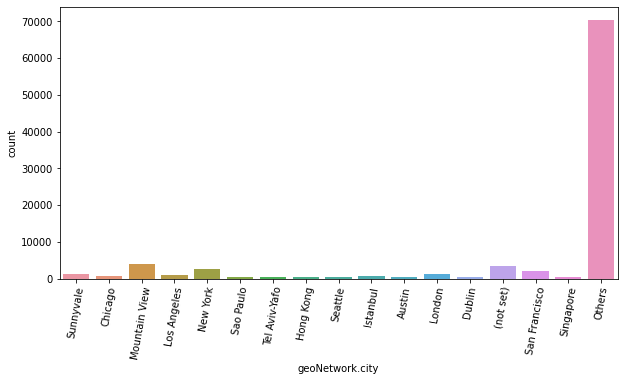

In [ ]:
# si yo tengo suficientes observaciones me interesa dejar los origenes originales 
plt.figure(figsize = (10,5))
sns.countplot(df['geoNetwork.city'])
plt.xticks(rotation=80)


## Geonetwork. network domain

In [ ]:
df['geoNetwork.networkDomain'].value_counts()



(not set)          24439
unknown.unknown    14447
comcast.net         2927
rr.com              1500
ttnet.com.tr        1369
                   ...  
asisystem.com          1
dbedt.net              1
n-kokudo.co.jp         1
dcs.co.zm              1
hyogo-c.ed.jp          1
Name: geoNetwork.networkDomain, Length: 7110, dtype: int64

In [ ]:
df['geoNetwork.networkDomain'].value_counts().head(5)

(not set)          24439
unknown.unknown    14447
comcast.net         2927
rr.com              1500
ttnet.com.tr        1369
Name: geoNetwork.networkDomain, dtype: int64

In [ ]:
df['network_net'] = df['geoNetwork.networkDomain'].str.contains('.net', case = False).astype(int)

In [ ]:
df['network_com'] = df['geoNetwork.networkDomain'].str.contains('.com', case = False).astype(int)

In [ ]:
df.drop('geoNetwork.networkDomain', axis =1 , inplace = True)

In [ ]:
explore_cat_values(df, 'network_net',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
network_net,,,,,
0,64344,0.712961,848,0.013179,50.56
1,25905,0.287039,329,0.012700,49.96


In [ ]:
explore_cat_values(df, 'network_com',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
network_com,,,,,
0,76068,0.842868,1076,0.014145,51.92
1,14181,0.157132,101,0.007122,37.98


## New visits

In [ ]:
df['totals.newVisits'].describe()

count     69990
unique        1
top           1
freq      69990
Name: totals.newVisits, dtype: object

In [ ]:
df['totals.newVisits'].fillna(0, inplace = True)

In [ ]:
df['totals.newVisits'] = df['totals.newVisits'].astype(int)

In [ ]:
explore_cat_values(df, 'totals.newVisits',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
totals.newVisits,,,,,
0,20259,0.224479,733,0.036181,58.93
1,69990,0.775521,444,0.006344,36.88


## Bounces

In [ ]:
df['totals.bounces'].describe()

count     45130
unique        1
top           1
freq      45130
Name: totals.bounces, dtype: object

In [ ]:
df['totals.bounces'].fillna(0, inplace = True)

In [ ]:
df['totals.bounces'] = df['totals.bounces'].astype(int)

In [ ]:
explore_cat_values(df, 'totals.bounces',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
totals.bounces,,,,,
0,45119,0.499939,1177,0.026087,50.02


In [ ]:
df.drop('totals.bounces', axis = 1, inplace = True)

In [ ]:
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90249,8,Organic Search,37993
device.browser,90249,9,Chrome,62130
device.operatingSystem,90249,7,Windows,34835
device.deviceCategory,90249,3,desktop,66492
geoNetwork.continent,90249,6,Americas,44972
geoNetwork.subContinent,90249,23,Northern America,39026
geoNetwork.country,90249,9,Others,37031
geoNetwork.region,90249,339,not available in demo dataset,50610
geoNetwork.metro,90249,82,not available in demo dataset,50610
geoNetwork.city,90249,17,Others,70433


In [ ]:
df.drop(['geoNetwork.region','geoNetwork.metro'], axis = 1, inplace = True)

In [ ]:
def OHE(col_name,dataframe):
  _dummy_dataset = pd.get_dummies(dataframe[col_name], prefix = col_name)
  dataframe = pd.concat([dataframe,_dummy_dataset], axis = 1)
  return dataframe.drop([col_name], axis =1)

In [ ]:
for col in df.describe(exclude = np.number).columns:
  df = OHE(col,df)

In [ ]:
df.shape

(90249, 102)

## Modelling

In [ ]:
df[['visitWithTransaction',TARGET]]

,visitWithTransaction,totals.transactionRevenue
sessionId,,
377306020877927890_1472880147,0,0.0
537222803633850821_1472812602,0,0.0
9499785259412240342_1472812272,0,0.0
357659889600827884_1472839882,0,0.0
3696906537737368442_1472856874,0,0.0
...,...,...
533119567408419467_1483573456,0,0.0
0617024530428033097_1483561021,0,0.0
469840327005431380_1483573235,0,0.0


In [ ]:
df.drop(['visitWithTransaction',TARGET], axis = 1, inplace = True)

### Particion entre development y validation

In [ ]:
df.pivot_table(index = ['year','month'], values = TARGET_LN, aggfunc = len)

totals.transactionRevenueLN
year month                             
2016 8                             7418
     9                             7134
     10                            9803
     11                           11304
     12                            8037
2017 1                             6506
     2                             6226
     3                             6878
     4                             6598
     5                             6539
     6                             6403
     7                             7138
     8                              265

In [ ]:
# tenemos solo un año completo, ago'17 tiene muy pocos dias , 201600 + mes , 201609 (sep'16)

In [ ]:
df_val = df[df['year']*100 + df['month'] >= 201706]
df_dev = df[df['year']*100 + df['month'] < 201706]
#estrategia de validacion es coger meses mas recientes

In [ ]:
df_val.shape

(13806, 100)

In [ ]:
df_val_X = df_val.drop(TARGET_LN, axis = 1)
df_val_y = df_val[[TARGET_LN]]

df_dev_X = df_dev.drop(TARGET_LN, axis = 1)
df_dev_y = df_dev[[TARGET_LN]]

### division entre train y test destro del development

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state= 42,
    test_size = 0.2
)

In [ ]:
df_dev_X.shape

(76443, 99)

### lanzar nuestro primer modelo

In [ ]:
# Instanciar el modelo
first_model = xgb.XGBRegressor(random_state = 42, max_depth = 4,min_child_weight= 20, n_estimators= 80)
#n_estimators: numero de iteraciones, a mas iteraciones más probable es el overfitting

In [ ]:
%%time
#entrenar el modelo
first_model.fit(X_train, y_train)

[19:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 13.6 s, sys: 148 ms, total: 13.8 s
Wall time: 13.8 s


XGBRegressor(max_depth=4, min_child_weight=20, n_estimators=80, random_state=42)

In [ ]:
# prediccion modelo

In [ ]:
test_prediction = pd.DataFrame(first_model.predict(X_test), columns = ['Prediction'], index = X_test.index)

In [ ]:
#evaluar

In [ ]:
results_df = y_test.join(test_prediction)

In [ ]:
results_df.sort_values(by = TARGET_LN, ascending = False ).head()

,totals.transactionRevenueLN,Prediction
sessionId,,
1957458976293878100_1492616459,8.208470,2.306387
244535803596038100_1470682666,7.205286,0.104655
1740516675967625074_1484791498,6.779808,0.444278
1665883834078021725_1480472776,6.636786,1.877519
7311242886083854158_1481924344,6.482710,3.297914


In [ ]:
#top 5 sesiones que mas han gastado
# el dataset esta muy desbalanceado , el algoritmo solo ve ejemplos de gente que no compra o compra poco importe
#el resultado es que sistemáticamente, el valor predicho es menor al valor real

In [ ]:
results_df.columns = ['Target','Prediction']

In [ ]:
results_df['error'] = results_df['Target'] - results_df['Prediction']

In [ ]:
results_df['squarred_error'] = results_df['error'] ** 2

In [ ]:
results_df

,Target,Prediction,error,squarred_error
sessionId,,,,
4813739199903315053_1493762891,0.0,0.081284,-0.081284,6.607038e-03
9999906724458612544_1488943249,0.0,0.000515,-0.000515,2.656078e-07
8013426547904286270_1491031969,0.0,0.000515,-0.000515,2.656078e-07
763390296085540505_1487718155,0.0,0.000508,-0.000508,2.584380e-07
4691788681189750512_1484143098,0.0,0.000515,-0.000515,2.656078e-07
...,...,...,...,...
6652890707114235755_1490056776,0.0,0.000515,-0.000515,2.656078e-07
068535038137025654_1472420190,0.0,0.114853,-0.114853,1.319132e-02
7624640672598132042_1486712497,0.0,0.000515,-0.000515,2.656078e-07


In [ ]:
results_df['root_squarred_error'] = np.sqrt(results_df['squarred_error'])

In [ ]:
mse = results_df['squarred_error'].mean()
rmse = results_df['root_squarred_error'].mean()

In [ ]:
mse

0.1597751393929077

In [ ]:
rmse

0.07127785842152405

In [ ]:
# modelo más tonto target = 0 - el error de este modelo es igual al target 

In [ ]:
results_df['sqr_error_tonto'] = results_df['Target'] ** 2

In [ ]:
mse_tonto = results_df['sqr_error_tonto'].mean()

In [ ]:
mse_tonto

0.23122847374437394

## Rebalancear el dataset

In [ ]:
#undersamplig
df_dev_nonzero = df_dev[df_dev[TARGET_LN]> 0 ] #se queda igual
df_dev_zero = df_dev[df_dev[TARGET_LN]== 0 ] # vamos a coger valores random 

In [ ]:
n_zeros = len(df_dev_nonzero)*4

In [ ]:
#80% zeros, 20% non zeros

In [ ]:
# cuanto mas parecido al 50%-50%, pero el undersampling nos quita observaciones

In [ ]:
df_dev_zero_sample = df_dev_zero.sample(n =n_zeros, random_state= 42 )

In [ ]:
df_dev_zero_sample.shape

(3900, 100)

In [ ]:
df_dev_sample=pd.concat([df_dev_zero_sample,df_dev_nonzero])

### lanzar un nuevo modelo con la verison rebalanceada

In [ ]:
df_dev_sample_X = df_dev_sample.drop(TARGET_LN, axis = 1)
df_dev_sample_y = df_dev_sample[[TARGET_LN]]

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = model_selection.train_test_split(
    df_dev_sample_X,
    df_dev_sample_y,
    random_state= 42,
    test_size = 0.2
)

In [ ]:
# Instanciar el modelo
reduced_model = xgb.XGBRegressor(random_state = 42, max_depth = 4,min_child_weight= 20, n_estimators= 80)
#n_estimators: numero de iteraciones, a mas iteraciones más probable es el overfitting

In [ ]:
reduced_model.fit(X_train_r,y_train_r)

[19:49:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=4, min_child_weight=20, n_estimators=80, random_state=42)

In [ ]:
test_prediction_r = pd.DataFrame(reduced_model.predict(X_test_r), columns = ['Prediction'], index = X_test_r.index)

In [ ]:
results_df_r = y_test_r.join(test_prediction_r)

In [ ]:
results_df_r.sort_values(by = 'Target', ascending = False).head()

KeyError: ignored

In [ ]:
# todavia estamos en una situacion en que predecimos por debajo del valor real del target
# necesitamos rebalancear mas el dataset

In [ ]:
results_df_r.columns = ['Target','Prediction']

In [ ]:
results_df_r['Error'] = results_df_r['Target'] - results_df_r['Prediction']

In [ ]:
results_df_r['sq_Error'] = results_df_r['Error'] ** 2

In [ ]:
mse_r = results_df_r['sq_Error'].mean()

In [ ]:
mse_r

In [ ]:
## mse_r mucho más alto, porque la distribucion ha cambiado
## modelo tonto, predice siempre 0, se va a equivocar un 20% de las veces 

In [ ]:
results_df_r['error_tonto'] = results_df_r['Target'] ** 2

In [ ]:
results_df_r['error_tonto'].mean()